---
title: "Implementing Logistic Regression"
author: "Jiffy Lesica"
---

## Abstract

In this blog post, I [implement logistic regression](https://github.com/jiffylesica/jiffylesica.github.io/blob/94b09d610a8a8dd845162b6cd58ef98b3f6ccc51/posts/Implementing%20Logistic%20Regression/logistic.py) from scratch using PyTorch and apply it to both computer-generated and real-world data. I begin by developing a LogisticRegression class and GradientDescentOptimizer class that supports both vanilla gradient descent and momentum-based updates. Through a series of experiments, I analyzed the relationship of changing learning rates, momentum/beta rates, overfitting, and real-world datasets with the logistic regression algorithm. The experiments include generating 2D data for visualizing decision boundaries, a higher-dimensional overfitting case, and a real-world bot vs. user classification dataset from [Kaggle](https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification). Each experiment is paired with visualizations and reflections to illustrate key concepts of the blog post.

In [18]:
import torch
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Clarifying torch.mean dimensions
X = torch.tensor([
    [1.0, 2.0, 3.0],
    [1.0, 2.0, 3.0],
    [1.0, 2.0, 3.0]   
])

print(torch.mean(X, dim = 0)) # Averages all elements in a column
print(torch.mean(X, dim = 1)) # Averages all elements in a row

tensor([1., 2., 3.])
tensor([2., 2., 2.])


In [20]:
# Just confirmation that the pyfile contents work properly

X = torch.tensor([
    [1.0, 2.0, 1.0],
    [2.0, 1.0, 1.0],
    [0.0, 3.0, 1.0]   
])
y = torch.tensor([0.0, 1.0, 1.0])

model = LogisticRegression()
model.w = torch.tensor([0.1, -0.2, 0.0])

print("Scores:", model.score(X))
print("Loss:", model.loss(X, y))
print("Gradient:", model.grad(X, y))

Scores: tensor([-0.3000,  0.0000, -0.6000])
Loss: tensor(0.7617)
Gradient: tensor([-0.1915, -0.5286, -0.2400])


In [21]:
# Define functions to create classification data, plot logistic classification data
# and draw a line on classification plot

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

def plot_logistic_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

X, y = classification_data(noise = 0.5)

*This function trains a logistic regression model on a given dataset using gradient descent (with optional momentum) and visualizes the training process. It tracks the logistic loss over 100 iterations and plots the loss curve to illustrate convergence results. If the input data has 2 features (plus a bias term), it also plots the decision boundary over the dataset.*

In [40]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def logistic_loss_and_plot(X, y, alpha=0.1, beta=0.0, max_iters=400):
    # Instantiate the model and optimizer
    model = LogisticRegression()
    model.score(X)  # ensure w is initialized
    opt = GradientDescentOptimizer(model)

    # Track loss over iterations
    loss_vec = []

    for _ in range(max_iters):
        loss = model.loss(X, y)
        loss_vec.append(loss.item())
        opt.step(X, y, alpha=alpha, beta=beta)

    print(f"Final Loss: {loss_vec[-1]:.4f} after {max_iters} iterations.")

    # Plot loss per iteration
    plt.figure(figsize=(6, 4))
    plt.plot(loss_vec, color="slategrey", linewidth=1.5)
    plt.scatter(range(len(loss_vec)), loss_vec, color="slategrey", edgecolors="black", s=10)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(f"Final Loss: {loss_vec[-1]:.4f} after {len(loss_vec)} iterations.", fontsize=12)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

    # If data is 2D, also plot decision boundary
    if X.shape[1] == 3:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.set(xlim=(-1, 2), ylim=(-1, 2))
        plot_logistic_data(X, y, ax)

        # Draw logistic decision boundary
        draw_line(model.w, -1, 2, ax, color="black")
        ax.set_title("Decision Boundary (Logistic Regression)")
        plt.show()

### Experiment 1: Visualizing Convergence on Computer Generated Data

In this experiment,I generate 2D classification data using the classification_data() function. The data is linearly separable with moderate noise. I train a logistic regression model using **vanilla gradient descent** and visualize the decision boundary and loss curve over 100 iterations. This aims to show that my logistic regression implementation correctly converges, decreases monotonically, and that a decision boundary can be visualized.

Plot for beta = 0.0
Final Loss: 0.0502 after 400 iterations.


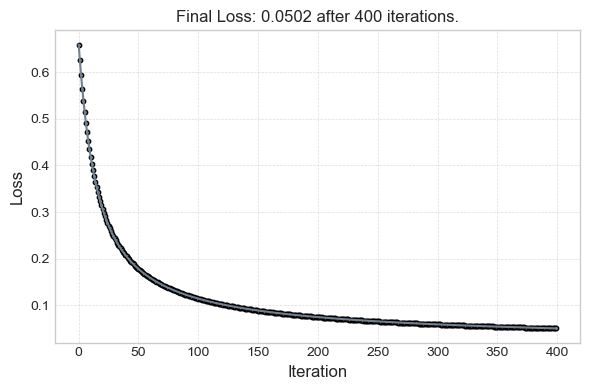

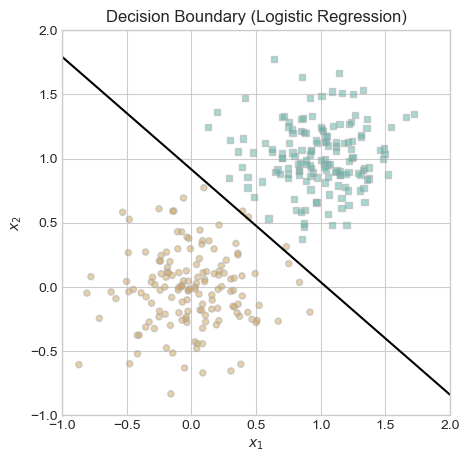

In [41]:
X, y = classification_data(noise=0.3, p_dims=2)
print("Plot for beta = 0.0")
logistic_loss_and_plot(X, y, alpha=0.5, beta=0.0)


## Experiment 2: Gradient Descent with momentum

Using the same dataset as Experiment 1, I compare **vanilla gradient descent** with **momentum-based gradient descent**. I train each model for the same number of iterations and plot the training loss over time. This aims to show how momentum accelerates convergence and leads to a lower loss being achieved earlier than vanilla gradient descent (as seen above).

Plot for beta = 0.9
Final Loss: 0.0166 after 400 iterations.


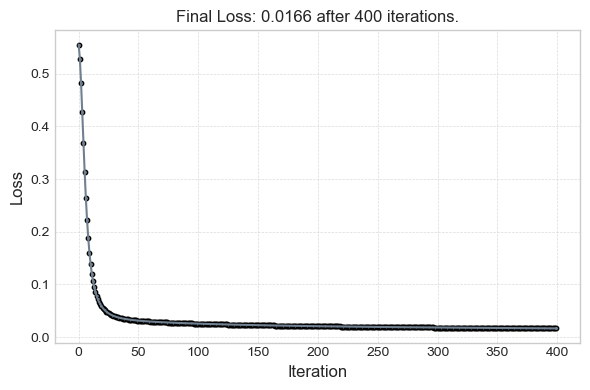

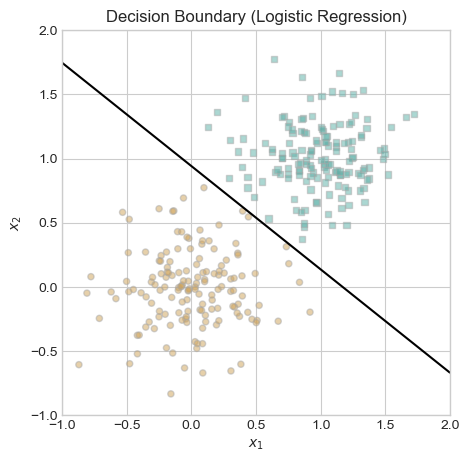

In [42]:
print("Plot for beta = 0.9")
logistic_loss_and_plot(X, y, alpha=0.5, beta=0.9)

### Experiment 3: Overfitting in Higher Dimensional Space

To illustrate overfitting, I generate data where the number of features **p > n**. I train the model on the training set with more features than datapoints until it achieves near **perfect accuracy**, and then evaluate performance on the test set which has more datapoints than features. This experiment aims to show that while a model with a lot of features can lead to good training results, it can produce overfitting. Just because you achieve good loss does not mean you will have good accuracy on test data.

Final Loss: 0.0030 after 400 iterations.


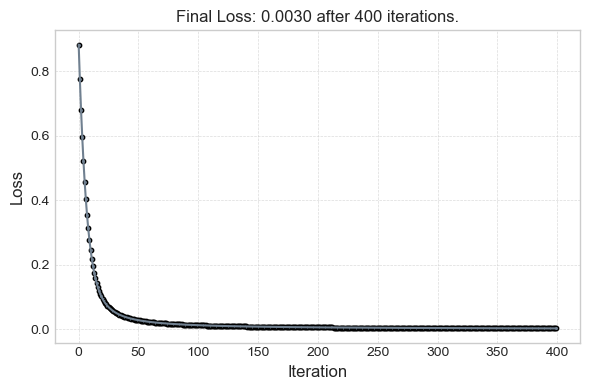

In [43]:
# Fewer data points, more dimensions = overfitting risk
X_train, y_train = classification_data(n_points=30, p_dims=100, noise=0.3)
X_test, y_test = classification_data(n_points=300, p_dims=100, noise=0.3)

# Plot training loss
logistic_loss_and_plot(X_train, y_train, alpha=0.5, beta=0.0)

In [26]:
# Recreate model for evaluation - logistic_loss_and_plot doesn't create global models
model = LogisticRegression()
model.score(X_train)
opt = GradientDescentOptimizer(model)

for _ in range(100):
    opt.step(X_train, y_train, alpha=0.1, beta=0.0)

train_accuracy = (model.predict(X_train) == y_train)
test_accuracy = (model.predict(X_test) == y_test)

print(f"Train Accuracy: {train_accuracy.float().mean():.4f}")
print(f"Test Accuracy:  {test_accuracy.float().mean():.4f}")


Train Accuracy: 1.0000
Test Accuracy:  0.8867


### In this section, I analyze a [real-world dataset](https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification) containing features from user profiles on a Russian social media platform, VKontakte. The goal od this analysis is to train a model to predict whether a profile is a bot (target = 1) or a human (target = 0). I implement this using a logistic regression model with gradient descent, both with and without momentum. The analysis includes the following steps:

1. Data preprocessing: All feature values from the dataset must be converted to numeric values. I will drop column entries that are mostly missing, as well as data entries with absent values. Then I will split the dataset into training and test set using train-test split from scikit learn.
2. Feature engineering
3. Train the Model: Fit the logistic regression model using gradient descent with and without momentum.
4. Visualize Results: Plot the training loss data across gradient descent iterations for both approaches mentioned in step 3.
5. Calculate the accuracy of the model on test data.

### Step 1: Data Loading and Preprocessing

*Notes on data provided on Kaggle*

- Numerical features have NaNs preserved on purpose (i.e. these missing values might carry a meaning, such as inactivity)
- Categorical features: Any missing values are explicitly labeled 'unknown', and Boolean values are already converted to binary where applicable

As such, preprocessing should be optimized to only transform/pre-process entries where necessary, with these feature notes kept in mind. In other words, 'unknown' entries can be converted to 0 (not removed) and NaNs should be left in place/unchanged.

In [27]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Loading and Preprocessing

# Load the data
df = pd.read_csv("bots_vs_users.csv")

# Replace 'Unknown' with 0 to indicate missing categorical value
df.replace("Unknown", 0.0, inplace=True)

# The only feature with string entry values is 'city', so we one-hot encode it
# This creates a new column for each unique city value, with binary 0.0/1.0 value
# Since there are only 4 distinct entries for this feature, this operation preferred to factorizing these values
df = pd.get_dummies(df, columns=["city"], dtype=float)

# Now, since we have possibly meaningful NaN values, i choose to replace them with -1
df = df.fillna(-1.0)

# Drop the target column to create X and y
X_df = df.drop("target", axis=1)

# Convert the feature matrix and target column to NumPy array for eventually use with PyTorch
# Include astype(float) to ensure any possible type object entries are made into floats
X_np = X_df.astype(float).values
y = df["target"].values

# Scale the data to make sure all features on same scale
scaler = StandardScaler()
X = scaler.fit_transform(X_np)


### Splitting the Data: Train/Validation/Test Split

In [28]:
# Split data into train (60%) and temp (40%) sets (To be turned to test and validation)
"""
I choose to pass stratify = y so that target distribution is maintained
Stratify makes sure that the distribution of entries in a certain column 
stays the same in the output data subset. In this case, we want the 
distribution of bots and users to be the same. So, for example, say the 
original dataset had 50% bots and 50% users, us passing y to stratify
will ensure those proportions are maintained in X_train/y_train and 
X_temp/y_temp
"""
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.6, random_state=802, stratify=y
)

# Split temp set evenly into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, train_size=0.5, random_state = 802, stratify=y_temp
)

# Convert these to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_validation = torch.tensor(X_val, dtype=torch.float32)
y_validation = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### Training Loop Function

In [29]:
def train_model(X_train, y_train, X_val, y_val, alpha=0.1, beta=0.0, num__iterations = 100):
    LR = LogisticRegression()
    opt = GradientDescentOptimizer(LR)
    train_losses = []
    val_losses = []

    # Perform training iterations
    for i in range(num__iterations):

        # Since beta activates momentum in step, pass 0.0 unless otherwise indicated in function call
        opt.step(X_train, y_train, alpha=alpha, beta=beta)

        # Track the loss
        # .item() extracts the Python scalar bc loss returns Tensor
        train_loss = LR.loss(X_train, y_train).item()
        val_loss = LR.loss(X_val, y_val).item()

        # Append loss to arrays for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return LR, train_losses, val_losses

### Run the Training Loop Function

In [30]:
# Each function call below runs a training loop on our training/validation data.
# The first call uses vanilla gradient descent (beta = 0.0)
# The second call uses gradient descent with momentum (0.9)

vanilla_LR, vanilla_train_loss, vanilla_validation_loss = train_model(
    X_train, y_train, X_validation, y_validation, alpha=0.05, beta=0.0, num__iterations=100 
)

momentum_LR, momentum_train_loss, momentum_validation_loss = train_model(
    X_train, y_train, X_validation, y_validation, alpha=0.05, beta=0.9, num__iterations=100 
)

### Plot Loss Curves

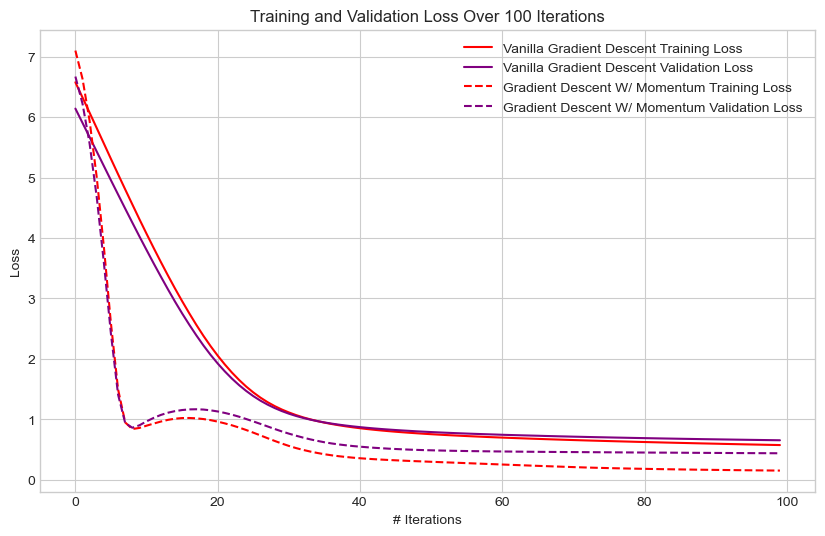

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot 4 loss combinations

plt.plot(vanilla_train_loss, 
         label="Vanilla Gradient Descent Training Loss", 
         linestyle="-", 
         color = "red")

plt.plot(vanilla_validation_loss, 
         label="Vanilla Gradient Descent Validation Loss", 
         linestyle="-", 
         color = "purple")

plt.plot(momentum_train_loss, 
         label="Gradient Descent W/ Momentum Training Loss", 
         linestyle="--", 
         color = "red")

plt.plot(momentum_validation_loss, 
         label="Gradient Descent W/ Momentum Validation Loss", 
         linestyle="--", 
         color = "purple")

# Give plot a title
plt.title("Training and Validation Loss Over 100 Iterations")

# X-axis title
plt.xlabel("# Iterations")

# y-label
plt.ylabel("Loss")

plt.legend()
plt.grid(True)

plt.show()

### Test Data Accuracy and Loss

In [32]:
def test_model(model, X_test, y_test):
    preds = model.predict(X_test)
    accuracy = (preds == y_test).float().mean().item()
    loss = model.loss(X_test, y_test).item()

    return accuracy, loss

In [33]:
vanilla_accuracy, vanilla_loss = test_model(vanilla_LR, X_test, y_test)
momentum_accuracy, momentum_loss = test_model(momentum_LR, X_test, y_test)

print(f"Vanilla Gradient Descent: \nAccuracy = {vanilla_accuracy:.4f}; \nLoss = {vanilla_loss:.2f}\n")
print(f"Gradient Descent W/ Momentum: \nAccuracy = {momentum_accuracy:.4f}; \nLoss = {momentum_loss:.2f}")

Vanilla Gradient Descent: 
Accuracy = 0.9064; 
Loss = 0.53

Gradient Descent W/ Momentum: 
Accuracy = 0.9379; 
Loss = 0.45


Experiment 4 Conclusion: As we can see from the printed results, Vanilla gradient descent produces relatively high classification accuracy, but with a higher loss. This means the vanilla algorithm is less calibrated. As we transition to gradient descent with momentum, we achieve a higher accuracy AND lower loss, suggesting that keeping a record of prior model training steps can help improve future results!

# Conclusion

In this blog post, I programmed and tested a from-scratch implementation of logistic regression, which could be used with both vanilla and momentum-based gradient descent. I validated my implementation using low-dimensional generated data, demonstrating the benefits of momentum for faster convergence, and explored the dangers of overfitting in high-dimensional settings. Finally, I applied my model to a real-world bot detection dataset, where momentum again helped achieve strong results. Through this process, I gained a deeper understanding of the mathematical foundations of logistic loss, the practical impact of optimization classes, and the importance of thoughtful preprocessing when working with real data.
